### Working with neuroimaging data in Python



In [3]:
import nibabel as nib
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import nilearn
import nilearn.plotting
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd


#### Data setup

For this exercise we will data from a study by Smeets et al. shared in [OpenNeuro](https://openneuro.org/datasets/ds000157/versions/00001).  The study is a blocked design in which subjects were shown pictures of food and non-food images. We will look at one run from one subject as an example.  We first need to download the relevant data files from OpenNeuro, obtaining them directly from Amazon Web Services using the `boto3` package.  These data are stored in [BIDS](http:/bids.neuroimaging.io) format, which makes it easy to identify which files we need for the analysis.

In [4]:
raw_dir = 'ds000157'
fmriprep_dir = raw_dir + '-fmriprep'
task = 'passiveimageviewing'
run = '' # '_run-1'
ses = '' #'_ses-test'
sub = 'sub-01'
space = '' # '_space-MNI152NLin2009cAsym_res-2'

images = {
        'mask': f"{sub}/func/{sub}{ses}_task-{task}{run}{space}_desc-brain_mask.nii.gz",
        'bold': f"{sub}/func/{sub}{ses}_task-{task}{run}{space}_desc-preproc_bold.nii.gz",
        'boldref': f"{sub}/func/{sub}{ses}_task-{task}{run}{space}_boldref.nii.gz",
        'confounds': f"{sub}/func/{sub}{ses}_task-{task}{run}{space}_desc-confounds_timeseries.tsv"
}

images = {k: os.path.join(fmriprep_dir, v) for k, v in images.items()}
# 
events = {'events': f"sub-01/{ses.replace('_', '')}func/sub-01{ses}_task-{task}{run}_events.tsv"}
# f'task-{task}{run}_events.tsv'}

events = {k: os.path.join(raw_dir, v) for k, v in events.items()}

def get_data(files, s3_bucket='openneuro-derivatives'):

    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    for label, file in files.items():
        if os.path.exists(file):
            print('using existing file:', file)
            continue
        outfile = file
        if 'derivatives' in s3_bucket:
            file = os.path.join('fmriprep', file)
        if not os.path.exists(os.path.dirname(outfile)):
            os.makedirs(os.path.dirname(outfile))
        print(f'downloading {label}: {file} to {outfile}')
        s3.download_file(s3_bucket, file, outfile)

get_data(images)
get_data(events, s3_bucket='openneuro.org')



using existing file: ds000157-fmriprep/sub-01/func/sub-01_task-passiveimageviewing_desc-brain_mask.nii.gz
using existing file: ds000157-fmriprep/sub-01/func/sub-01_task-passiveimageviewing_desc-preproc_bold.nii.gz
using existing file: ds000157-fmriprep/sub-01/func/sub-01_task-passiveimageviewing_boldref.nii.gz
using existing file: ds000157-fmriprep/sub-01/func/sub-01_task-passiveimageviewing_desc-confounds_timeseries.tsv
using existing file: ds000157/sub-01/func/sub-01_task-passiveimageviewing_events.tsv


### Displaying nifti images

The `nilearn` packages provides a number of [plotting tools](https://nilearn.github.io/dev/plotting/index.html) for neuroimaging data. First we will plot the BOLD reference image using `nilearn.plotting.plot_img`.  There are many different options, but by default it plots three orthogonal sections through the image.

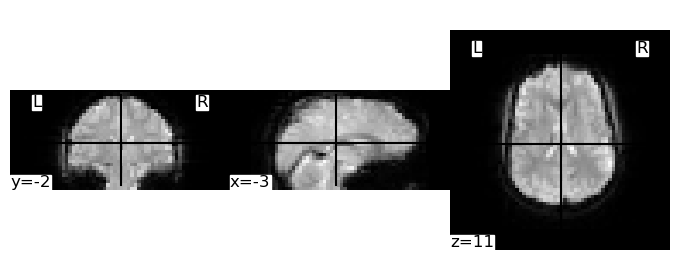

In [5]:

nilearn.plotting.plot_img(images['boldref'], cmap='gray')


### Loading data from nifti images

In many cases we would like to load the contents of a NIFTI image for further analysis.  We can do this using the `nibabel` package.  First, we can load the image and look at the information in the header.

In [6]:
img = nib.load(images['bold'])

print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  64  64  30 375   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.       4.       4.       3.98667  1.6      1.       1.       1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 4926.0034
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v1.4.9).'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -9.09205e-17
quatern_c       : -1.0
quat

There are two ways that we can access the data within the image object.  First, we can access them through via the `dataobj` property, which provides an `array proxy` that points to the data:

In [7]:
img.dataobj.shape

(64, 64, 30, 375)

In general it is prefered to load the data into a new variable, using the `get_fdata()` method of the image object:

In [8]:
data = img.get_fdata()
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(64, 64, 30, 375)


Now we can work with the data as we would with any Numpy array. For example, let's plot the timecourse of one voxel:

Text(0.5, 0, 'seconds')

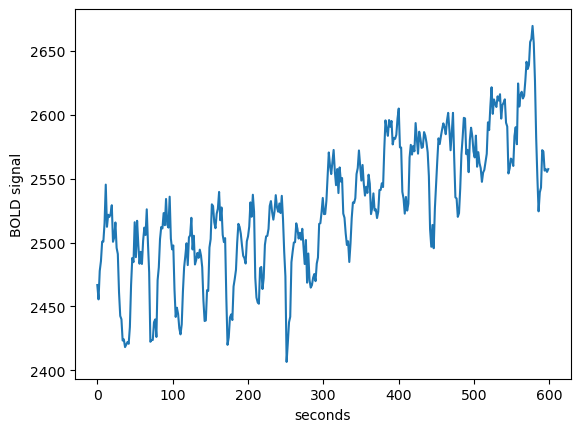

In [9]:
# plot a timeseries from one voxel

tr = img.header.get_zooms()[3]

imgtimes = np.arange(0, img.shape[3] * tr, tr)
plt.plot(imgtimes, data[36, 14, 6, :])
plt.ylabel('BOLD signal')
plt.xlabel('seconds')

### loading data from a set of voxels

For many analyses, we would prefer to load a 2-dimensional matrix, with a subset of voxels on one axis and timepoints on the other axis. For example, we might want to run an analysis only on voxels that are within the brain mask.  We can extract data from a set of mask voxels using nilearn's `NiftiMasker`:

In [10]:
masker = nilearn.maskers.NiftiMasker(images['mask'], standardize=True)
maskdata = masker.fit_transform(images['bold'])

print(maskdata.shape)

# confirm that the number of columns matches number of nonzero voxels in the brain mask

assert maskdata.shape[1] == np.sum(nib.load(images['mask']).dataobj)

(375, 19611)


#### Create a "carpet plot"

A "carpet plot" is a two-dimensional plot that presents voxel intensities as an image, with voxels on the Y axis and timepoints on the X axis ([Power, 2017](https://www.sciencedirect.com/science/article/abs/pii/S1053811916303871)).  They are a very useful way to visualize potential problems with an fMRI dataset.  Here we present a carpet plot for the fMRI dataset loaded above, along with a plot of mean global fMRI signal at each timepoint and framewise displacement (a measure of head motion).

Text(112.59722222222221, 0.5, 'framewise displacement')

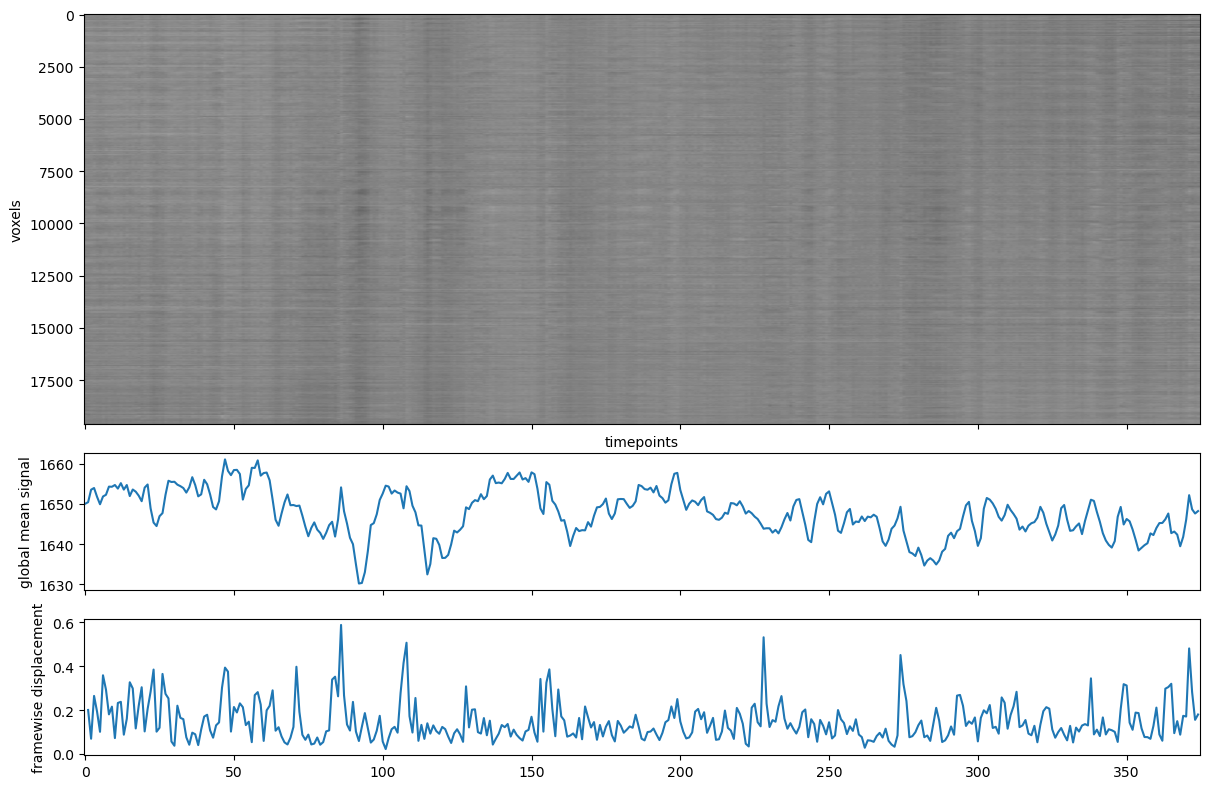

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# transpose the maskdata since we want timepoints on the X axis
ax[0].imshow(maskdata.T, aspect='auto', cmap='gray')
plt.tight_layout()
ax[0].set_ylabel('voxels')
_ = ax[0].set_xlabel('timepoints')

confound_df = pd.read_csv(images['confounds'], sep='\t')
ax[1].plot(confound_df.global_signal)
ax[1].set_ylabel('global mean signal')

ax[2].plot(confound_df.framewise_displacement)
ax[2].set_ylabel('framewise displacement')


Here we can see that head motion is sometimes associated with large whole-brain fluctuations in global signal, as described by Power and colleagues.

### Fitting a linear model to the data

In task fMRI we generally fit a linear model (based on the task, along with a set of confound regressors) to identify voxels that show a significant association with the task. The `nilearn` package has a set of functions for performing linear modeling analyses on fMRI data, which provide all of the functionality needed to analyze an fMRI dataset.  Here we provide a simple example by fitting the model to our example dataset from above.  To build the model, we need to load the file that specifies when the events happened during the scan.

In [12]:
# first set up the events file

events_df = pd.read_csv(events['events'], sep='\t')
if 'trial_type' not in events_df.columns:
    events_df['trial_type'] = task

Now we set up and estimate the model.

In [13]:
model = nilearn.glm.first_level.FirstLevelModel(t_r = tr,  smoothing_fwhm=5,
                                               mask_img=images['mask'],
                                               minimize_memory=False)
modelfit = model.fit(img, events_df[['onset', 'duration', 'trial_type']]) 

# extract the fitted response image
fitted_response = modelfit.predicted[0].get_fdata()




Having fit the model, we need to define a contrast in order to create the relevant statistical maps.  Here we will define a simple contrast that compares activity for both food and non-food images against a resting baseline.  The `generate_report()` method creates a report that provides various information about the contrast result. Here we correct for multiple comparisons using the false discovery rate (FDR) correction; this correction is generally not optimal for images ([Chumbley & Friston, 2009](https://pubmed.ncbi.nlm.nih.gov/18603449/)) but we use it here for convenience. We also impose a cluster size threshold of 30 voxels to remove small clusters.

In [14]:
conmtx = np.zeros(model.design_matrices_[0].shape[1])
conmtx[1:2] = 1  # set both food and nonfood to 1

modelfit.generate_report(conmtx, bg_img=images['boldref'],
                        cluster_threshold=30, height_control='fdr', alpha=.01)

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,0
slice_time_ref,0.0
smoothing_fwhm,5
standardize,False


In some cases we might want to work directly with the statistical images, which we can do by extracting them using the `compute_contrast()` method.

In [15]:
contrast_map = model.compute_contrast(conmtx, output_type='z_score')

_, z_threshold = threshold_stats_img(contrast_map, alpha=.01, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % z_threshold)

contrast_map_thresh = nilearn.image.threshold_img(contrast_map, threshold=z_threshold,
                                                  cluster_threshold=30, two_sided=False)

False Discovery rate = 0.05 threshold: 3.161


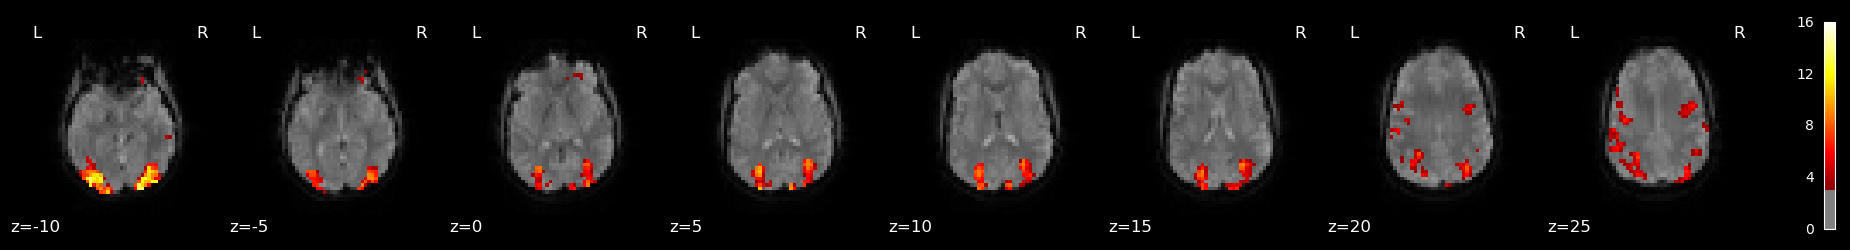

In [16]:
nilearn.plotting.plot_stat_map(contrast_map_thresh, threshold=z_threshold,
                               bg_img=images['boldref'], 
                               display_mode='z', cut_coords=np.arange(-10, 30, 5))

### Moving between voxel coordinates and spatial coordinates

There are two ways to refer to particular voxels in an image.  First, we can refer to their index along each of the dimensions of the image; for example, `[3, 5, 8]` would refer to the fourth voxel along the X axis (because indexing starts at zero), fifth voxel along the Y axis, and 8th voxel along the Z axis.  However, we can also refer to them in spatial coordinates, in which the location refers to the distance along each dimension from the *origin* of the image. In data that have been normalized to a standard space such as MNI space, this would refer to the origin (i.e. [0, 0, 0]) in that space; in unnormalized images the origin is usually the center of the image. 

The NIFTI header contains a matrix (known as the *affine* matrix, obtained using the `affine` property) that defines the relationship between voxel coordinates and spatial coordinates.  The affine matrix provides a way to translate between voxel and spatial coordinates by matrix multiplication; see [here](https://nipy.org/nibabel/coordinate_systems.html) for more detail on the use of affine matrices and homogenous coordinates in neuroimaging.  In short, the first three elements in the diagonal of the affine matrix contain the voxel sizes that allow scaling of the coordinates, the first three elements in the fourth column define the origin which specifies the translation of the coordinates, and the off-diagonal elements in the top 3 X 3 matrix define the rotation of the coordinates.

In [17]:
print(img.affine)

[[-4.00000000e+00 -9.28509995e-21  6.77625994e-21  1.21478996e+02]
 [ 7.27363974e-16  4.00000000e+00 -2.71050995e-20 -1.24000000e+02]
 [ 1.24155006e-16  4.84096005e-17  3.98667002e+00 -4.20836983e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [18]:
xyzcoords = [36, 14, 6, 1]
print('voxel coords:', xyzcoords)

# to convert from voxel coords to spatial coords, use dot product of sform with voxel coords
spatialcoords = img.affine.dot(np.array(xyzcoords))
print('spatial coords:', spatialcoords)

# to convert back from spatial coords to voxel coords, use dot product of inverse sform with spatial coords
reconverted = np.linalg.inv(img.affine).dot(spatialcoords)
print('converted back to voxel coords:', reconverted)

# use an assertion test to ensure that this worked
assert np.allclose(xyzcoords, reconverted)

voxel coords: [36, 14, 6, 1]
spatial coords: [-22.52100372 -68.         -18.16367817   1.        ]
converted back to voxel coords: [36. 14.  6.  1.]


We can use this knoweldge to extract the data from a particular coordinate and plot it against its fitted response from the model.  

r-squared = 0.8110353746170038


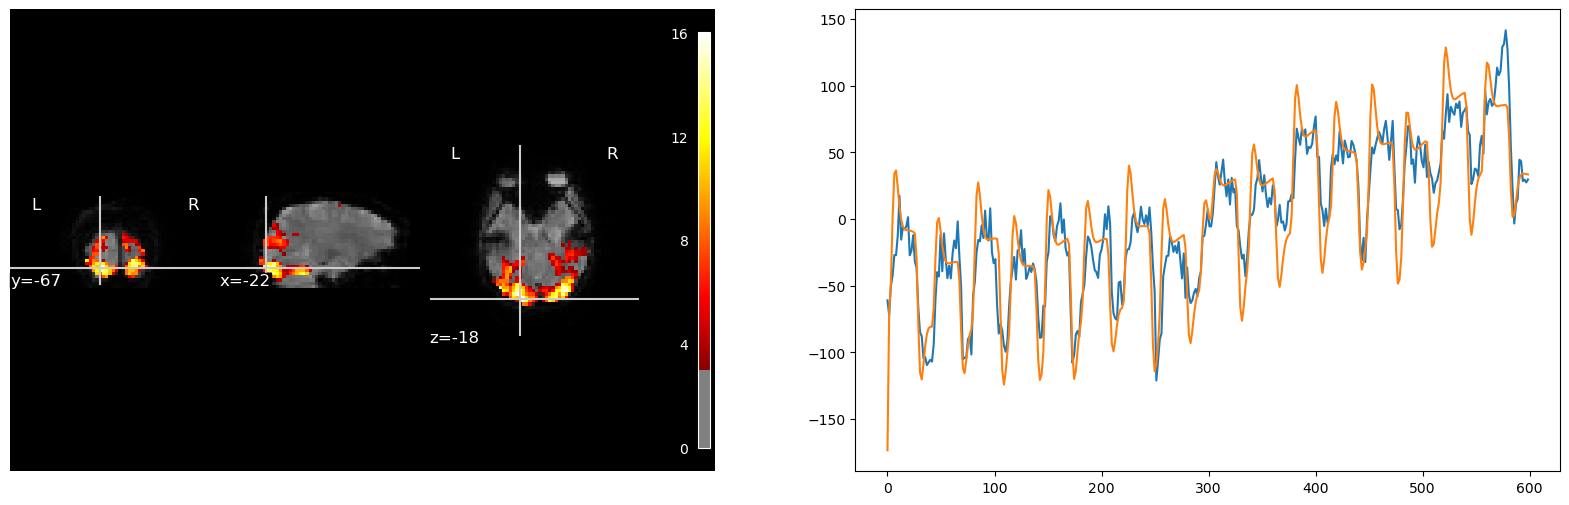

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

# nilearn expects spatial coordinates for its cut_coords argument
nilearn.plotting.plot_stat_map(contrast_map_thresh,  threshold=z_threshold,
                               bg_img=images['boldref'],  display_mode='ortho', axes=ax[0],
                              cut_coords = spatialcoords[:3])

# to extract the data, we need the voxel coords
voxelts = data[xyzcoords[0], xyzcoords[1], xyzcoords[2],  :]
voxelts = voxelts - np.mean(voxelts)
fittedts = fitted_response[xyzcoords[0], xyzcoords[1], xyzcoords[2],  :]

print(f'r-squared = {np.corrcoef(voxelts, fittedts)[0, 1] ** 2}')
ax[1].plot(imgtimes, voxelts)
hrfscale = 100 # scale for visualization
ax[1].plot(imgtimes,  fittedts * hrfscale)

In [20]:
maskdata.shape

(375, 19611)

In [21]:
from sdv.timeseries.deepecho import PAR

par = PAR()
maskdata_df = pd.DataFrame(maskdata)
par.fit(maskdata_df)

KeyboardInterrupt: 